In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils_notebook import get_logits_targets, modal_probs_decreasing

from collections import OrderedDict, Counter
import random
from typing import Dict


In [33]:
DATA = 'cifar100'
LIKELIHOOD = 'softmax'
EPOCH = 299
MODELS = ['models_repl', 'models_mono_weights', 'models_mono_weights_5', 'models_mono_penal', 'models_mono_penal_stop_grad']

logits_dict = {}
for model_name in MODELS:
    _logits, targets, _ = get_logits_targets(DATA, model_name, LIKELIHOOD, EPOCH, cuda=False, logits_type='test')
    logits_dict[model_name] = _logits

In [14]:
# MODEL_FOLDER = 'models_repl'
# LIKELIHOOD = 'softmax'
# EPOCH = 299


# logits, targets, ARGS = get_logits_targets('cifar100', MODEL_FOLDER, LIKELIHOOD, EPOCH, cuda=False)

In [31]:
acc_dict, mono_dict = {}, {}
for model_name in MODELS:
    logits = logits_dict[model_name]

    L = len(logits)
    N = len(targets)

    probs = torch.softmax(logits, dim=2)
    preds = {i: torch.argmax(probs, dim=2)[i, :] for i in range(L)}
    acc = [(targets == preds[i]).sum() / len(targets) for i in range(L)]
    msp = {i: torch.max(probs, dim=2).values[i, :] for i in range(L)}

    mono_modal_prob = [round(x, 4) for x in modal_probs_decreasing(preds, probs, layer=L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]
    mono_y_star = [round(x, 4) for x in modal_probs_decreasing(targets, probs, layer=None, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all").values()]

    print('Model:', model_name)
    print([round(float(x), 4) for x in acc])
    print(mono_modal_prob)
    print(mono_y_star)

    acc_dict[model_name] = acc
    mono_dict[model_name] = modal_probs_decreasing(preds, probs, layer=L, N=N, thresholds=[-0.0001, -0.01, -0.05, -0.1, -0.2, -0.25, -0.33, -0.5], diffs_type="all")

Model: models_repl
[0.632, 0.6566, 0.6772, 0.6993, 0.7125, 0.7206, 0.7207]
[87.72, 69.5, 58.02, 51.77, 43.15, 39.4, 33.99, 23.82]
[87.44, 67.04, 55.09, 48.91, 41.12, 37.82, 33.46, 25.2]
Model: models_mono_weights
[0.6158, 0.6631, 0.6827, 0.6941, 0.7024, 0.7076, 0.7137]
[87.46, 69.23, 58.14, 51.97, 43.53, 39.94, 34.82, 24.72]
[87.22, 67.01, 54.92, 49.0, 40.98, 37.91, 33.86, 25.69]
Model: models_mono_weights_5
[0.6151, 0.6542, 0.6819, 0.6991, 0.7082, 0.7128, 0.7124]
[86.4, 67.79, 57.32, 51.03, 42.75, 39.42, 34.48, 24.37]
[86.2, 65.64, 54.88, 48.77, 41.19, 38.31, 34.15, 26.04]
Model: models_mono_penal
[0.476, 0.6224, 0.6639, 0.6794, 0.6965, 0.7113, 0.7126]
[76.43, 61.7, 51.02, 43.97, 36.36, 33.6, 29.44, 22.28]
[76.92, 62.23, 50.04, 43.24, 35.76, 33.33, 30.08, 24.41]
Model: models_mono_penal_stop_grad
[0.5674, 0.6212, 0.6561, 0.6761, 0.6884, 0.6983, 0.7035]
[72.31, 60.28, 52.88, 48.19, 42.64, 40.36, 37.06, 30.63]
[72.16, 59.4, 51.86, 47.35, 42.08, 40.02, 37.06, 31.9]


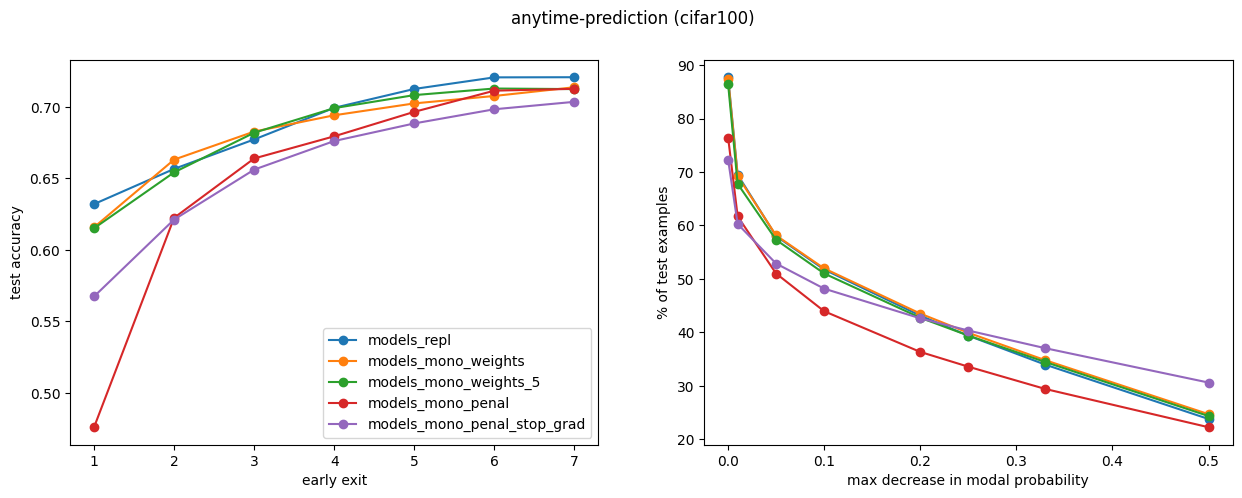

In [34]:
early_exits = [i + 1 for i in range(len(acc))]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for model_name in MODELS:
    ax[0].plot(early_exits, acc_dict[model_name], label=model_name, marker='o',)
    ax[1].plot(mono_dict[model_name].keys(), mono_dict[model_name].values(), marker='o', label=model_name)

ax[0].set_ylabel('test accuracy')
ax[0].set_xlabel('early exit') 
ax[1].set_xlabel('max decrease in modal probability')
ax[1].set_ylabel('% of test examples') 
ax[0].legend()

plt.suptitle(f'anytime-prediction ({DATA})')
plt.show()
